#### Setup

In [ ]:
! pip install transformers

In [ ]:
# Install Kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

In [2]:
import contextlib
from google.colab import files
import io

with contextlib.redirect_stdout(io.StringIO()):
    files.upload()

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c AI4Code

!  unzip /content/AI4Code.zip -d /content/data

! rm -rf /content/AI4Code.zip

### Imports and Globals

In [35]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import sparse
from tqdm import tqdm

pd.options.display.width = 180
pd.options.display.max_colwidth = 120

BERT_PATH = Path('/content/distil_bert_uncased')

os.makedirs(BERT_PATH, exist_ok=True)

data_dir = Path('/content/data')

### Read input data

In [21]:
NUM_TRAIN = 10000


def read_notebook(path):
    return (
        pd.read_json(
            path,
            dtype={'cell_type': 'category', 'source': 'str'})
        .assign(id=path.stem)
        .rename_axis('cell_id')
    )


paths_train = list((data_dir / 'train').glob('*.json'))[:NUM_TRAIN]
notebooks_train = [
    read_notebook(path) for path in tqdm(paths_train, desc='Train NBs')
]
df = (
    pd.concat(notebooks_train)
    .set_index('id', append=True)
    .swaplevel()
    .sort_index(level='id', sort_remaining=False)
)

df

Train NBs: 100%|██████████| 10000/10000 [00:59<00:00, 167.39it/s]


cell_type                                                                                                                   source
id             cell_id                                                                                                                                    
000a4651cce8f4 9ae35818      code  import os\nimport time\nimport requests\n\nimport jax\nimport jax.numpy as jnp\nfrom jax import jit, grad, random\n\...
               f1dee85b      code         def apply_activation(x):\n    return jnp.maximum(0.0, x)\n\ndef get_dot_product(W, X):\n    return jnp.dot(W, X)
               00e71412      code  # Always use a seed\nkey = random.PRNGKey(1234)\nW = random.normal(key=key, shape=[1000, 10000], dtype=jnp.float32)\...
               5bcfa9ad      code                                       # Make jaxpr for the activation function\nprint(jax.make_jaxpr(activation_jit)(Z))
               f417baab      code                                   # Make jaxpr for the activation function\nprint(jax.make_jaxpr(dot_product_jit)(W, X))
...                           ...                                                                                                                      ...
fffc30d5a0bc46 3ba953ee  markdown                                                                                              #### Checking the dataframe
               53125cfe  markdown                                                                          #### Checking the number of nulls in percentage
               63340e73  markdown                                                      #### Now we will try to impute null with the maximum occured values
               09727c0c  markdown                                                                                       #### Importing necessary libraries
               d3647ac8  markdown                                                                                #### Doing some exploratory data analysis

[455713 rows x 2 columns]

Let's analyse an example notebook.

* df created above contains all the commands (disordered)
* Order df (train_orders.csv) contains the order of the cells in the notebooks

In [7]:
nb_id = df.index.unique('id')[6]
print('Notebook:', nb_id)

print("The disordered notebook:")
nb = df.loc[nb_id, :]
display(nb)
print()

Notebook: 005732b128455c
The disordered notebook:


,cell_type,source
cell_id,,
3c9d50de,code,# This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/pyt...
8a48b85b,code,url = 'https://www.kaggleusercontent.com/episodes/4231325.json'
0adc9518,code,"import urllib, json\n\nresponse = urllib.request.urlopen(url)\ndata = json.loads(response.read())\n"
10de9bf7,code,data.keys()
940f99ee,code,data
ff6affb7,code,dict_obs = {}\nfor i in range(1000):\n player1 = data['steps'][i][0]\n player2 = data['steps'][i][1]\n dict...
27fdb8bd,code,df = pd.DataFrame(dict_obs)\ndf = df.T\ndf
603f43db,code,df.describe()
2be92532,code,import matplotlib.pyplot as plt


In [8]:
df_orders = pd.read_csv(
    data_dir / 'train_orders.csv',
    index_col='id',
    squeeze=True,
).str.split()  # Split the string representation of cell_ids into a list

df_orders

id
00001756c60be8    [1862f0a6, 448eb224, 2a9e43d6, 7e2f170a, 038b763d, 77e56113, 2eefe0ef, 1ae087ab, 0beab1cd, 8ffe0b25, 9a78ab76, 0d136...
00015c83e2717b    [2e94bd7a, 3e99dee9, b5e286ea, da4f7550, c417225b, 51e3cd89, 2600b4eb, 75b65993, cf195f8b, 25699d02, 72b3201a, f2c75...
0001bdd4021779    [3fdc37be, 073782ca, 8ea7263c, 80543cd8, 38310c80, 073e27e5, 015d52a4, ad7679ef, 7fde4f04, 07c52510, 0a1a7a39, 0bcd3...
0001daf4c2c76d    [97266564, a898e555, 86605076, 76cc2642, ef279279, df6c939f, 2476da96, 00f87d0a, ae93e8e6, 58aadb1d, d20b0094, 986fd...
0002115f48f982                                 [9ec225f0, 18281c6c, e3b6b115, 4a044c54, 365fe576, a3188e54, b3f6e12d, ee7655ca, 84125b7a]
                                                                           ...                                                           
fffc30d5a0bc46    [09727c0c, ff1ea6a0, ddfef603, a01ce9b3, 3ba953ee, bf92a015, f4a0492a, 095812e6, 53125cfe, aa32a700, 63340e73, 06d8c...
fffc3b44869198    [978a5137, fa

In [11]:
len(df_orders.loc[nb_id])

14

In [10]:
cell_order = df_orders.loc[nb_id]

print("The ordered notebook:")
nb.loc[cell_order, :]

The ordered notebook:


,cell_type,source
cell_id,,
3c9d50de,code,# This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/pyt...
3619e413,markdown,Credits goes to https://www.kaggle.com/arunprathap/replay-json-eda-i for this notebook
8a48b85b,code,url = 'https://www.kaggleusercontent.com/episodes/4231325.json'
b79c37ef,markdown,## Load Replay
0adc9518,code,"import urllib, json\n\nresponse = urllib.request.urlopen(url)\ndata = json.loads(response.read())\n"
04b2e812,markdown,## Explore Replay
10de9bf7,code,data.keys()
940f99ee,code,data
ff6affb7,code,dict_obs = {}\nfor i in range(1000):\n player1 = data['steps'][i][0]\n player2 = data['steps'][i][1]\n dict...


Add rank to the cells in train_orders df

In [12]:
def get_ranks(base, derived):
    return [base.index(d) for d in derived]

# testing the function on the above example train_order sample
cell_ranks = get_ranks(cell_order, list(nb.index))
nb.insert(0, 'rank', cell_ranks)

nb

,rank,cell_type,source
cell_id,,,
3c9d50de,0,code,# This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/pyt...
8a48b85b,2,code,url = 'https://www.kaggleusercontent.com/episodes/4231325.json'
0adc9518,4,code,"import urllib, json\n\nresponse = urllib.request.urlopen(url)\ndata = json.loads(response.read())\n"
10de9bf7,6,code,data.keys()
940f99ee,7,code,data
ff6affb7,8,code,dict_obs = {}\nfor i in range(1000):\n player1 = data['steps'][i][0]\n player2 = data['steps'][i][1]\n dict...
27fdb8bd,9,code,df = pd.DataFrame(dict_obs)\ndf = df.T\ndf
603f43db,10,code,df.describe()
2be92532,11,code,import matplotlib.pyplot as plt


Assign correct cell order rank in the df created from raw data

In [16]:
# Step 1 : Add correct cell order to df, using order in df_orders 
df_orders_ = df_orders.to_frame().join(
    df.reset_index('cell_id').groupby('id')['cell_id'].apply(list),
    how='right',
)

# Step 2 - Get rank (here cell_order is base and cell_id retreived from df_orders is the derived)
ranks = {}
for id_, cell_order, cell_id in df_orders_.itertuples():
    ranks[id_] = {'cell_id': cell_id, 'rank': get_ranks(cell_order, cell_id)}

# Step 3 - Create a dataframe out of it
df_ranks = (
    pd.DataFrame
    .from_dict(ranks, orient='index')
    .rename_axis('id')
    .apply(pd.Series.explode)
    .set_index('cell_id', append=True)
)

df_ranks

rank
id             cell_id      
000a4651cce8f4 9ae35818    2
               f1dee85b    3
               00e71412    4
               5bcfa9ad    7
               f417baab    9
...                      ...
fffc30d5a0bc46 3ba953ee    4
               53125cfe    8
               63340e73   10
               09727c0c    0
               d3647ac8   14

[455713 rows x 1 columns]

Read in ancestors data

In [17]:
df_ancestors = pd.read_csv(data_dir / 'train_ancestors.csv', index_col='id')
df_ancestors

,ancestor_id,parent_id
id,,
00001756c60be8,945aea18,NaN
00015c83e2717b,aa2da37e,317b65d12af9df
0001bdd4021779,a7711fde,NaN
0001daf4c2c76d,090152ca,NaN
0002115f48f982,272b483a,NaN
...,...,...
fffc30d5a0bc46,6aed207b,NaN
fffc3b44869198,a6aaa8d7,NaN
fffc63ff750064,0a1b5b65,NaN


Merge ranks and ancestors to raw data

In [22]:
df = df.reset_index().merge(df_ranks, on=["id", "cell_id"]).merge(df_ancestors, on=["id"])
df

,id,cell_id,cell_type,source,rank,ancestor_id,parent_id
0,000a4651cce8f4,9ae35818,code,"import os\nimport time\nimport requests\n\nimport jax\nimport jax.numpy as jnp\nfrom jax import jit, grad, random\n\...",2,4db21994,NaN
1,000a4651cce8f4,f1dee85b,code,"def apply_activation(x):\n return jnp.maximum(0.0, x)\n\ndef get_dot_product(W, X):\n return jnp.dot(W, X)",3,4db21994,NaN
2,000a4651cce8f4,00e71412,code,"# Always use a seed\nkey = random.PRNGKey(1234)\nW = random.normal(key=key, shape=[1000, 10000], dtype=jnp.float32)\...",4,4db21994,NaN
3,000a4651cce8f4,5bcfa9ad,code,# Make jaxpr for the activation function\nprint(jax.make_jaxpr(activation_jit)(Z)),7,4db21994,NaN
4,000a4651cce8f4,f417baab,code,"# Make jaxpr for the activation function\nprint(jax.make_jaxpr(dot_product_jit)(W, X))",9,4db21994,NaN
...,...,...,...,...,...,...,...
455708,fffc30d5a0bc46,3ba953ee,markdown,#### Checking the dataframe,4,6aed207b,NaN
455709,fffc30d5a0bc46,53125cfe,markdown,#### Checking the number of nulls in percentage,8,6aed207b,NaN
455710,fffc30d5a0bc46,63340e73,markdown,#### Now we will try to impute null with the maximum occured values,10,6aed207b,NaN
455711,fffc30d5a0bc46,09727c0c,markdown,#### Importing necessary libraries,0,6aed207b,NaN


Is there any data skew?

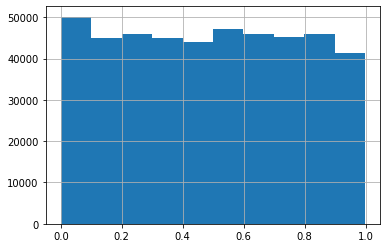

In [24]:
df["pct_rank"] = df["rank"] / df.groupby("id")["cell_id"].transform("count")

df["pct_rank"].hist(bins=10)

Doesn't look it!

Train-Valid Split

Since we want the entire notebook to be in either train or test split (or validation), we can use GroupShuffleSplit, using ancestor_id as per the data documentation

In [25]:
from sklearn.model_selection import GroupShuffleSplit

NVALID = 0.1  # size of validation set

splitter = GroupShuffleSplit(n_splits=1, test_size=NVALID, random_state=0)

train_ind, val_ind = next(splitter.split(df, groups=df["ancestor_id"]))

train_df = df.loc[train_ind].reset_index(drop=True)
val_df = df.loc[val_ind].reset_index(drop=True)

In [27]:
val_df.head()

,id,cell_id,cell_type,source,rank,ancestor_id,parent_id,pct_rank
0,006389dbcb0e43,ca4d9b20,code,# This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/pyt...,0,1e71b864,NaN,0.0
1,006389dbcb0e43,ffeed944,code,# Directories where the data is saved \n\ndata_dir_production = Path('../input/productionenergyfrance')\ndata_dir_cl...,5,1e71b864,NaN,0.075758
2,006389dbcb0e43,1bf0cece,code,"### Create functions to load the datasets\n\n# Lists with the name of the features and outputs, necessary to access ...",6,1e71b864,NaN,0.090909
3,006389dbcb0e43,3391149c,code,"sns.set(font_scale=5)\nfig, axes = plt.subplots(5, 2, figsize=(100,100))\nfor idx, column in enumerate(df_climate):\...",8,1e71b864,NaN,0.121212
4,006389dbcb0e43,4a44b992,code,### Analyze the data and search for zeros and missing values\n\ndef missing_zero_values_table(df):\n zero_val...,11,1e71b864,NaN,0.166667


In [30]:
val_df["cell_type"].value_counts()

code        30872
markdown    16321
Name: cell_type, dtype: int64

In [31]:
train_df_mark = train_df[train_df["cell_type"] == "markdown"].reset_index(drop=True)

val_df_mark = val_df[val_df["cell_type"] == "markdown"].reset_index(drop=True)

### Competition Metrics

In [28]:
from bisect import bisect


def count_inversions(a):
    inversions = 0
    sorted_so_far = []
    for i, u in enumerate(a):
        j = bisect(sorted_so_far, u)
        inversions += i - j
        sorted_so_far.insert(j, u)
    return inversions


def kendall_tau(ground_truth, predictions):
    total_inversions = 0
    total_2max = 0  # twice the maximum possible inversions across all instances
    for gt, pred in zip(ground_truth, predictions):
        ranks = [gt.index(x) for x in pred]  # rank predicted order in terms of ground truth
        total_inversions += count_inversions(ranks)
        n = len(gt)
        total_2max += n * (n - 1)
    return 1 - 4 * total_inversions / total_2max

Test out the metrics on example

In [41]:
y_dummy = val_df.groupby('id')['cell_id'].apply(list)
kendall_tau(df_orders.loc[y_dummy.index], y_dummy)

0.3894549455166657

### Modelling

#### Download and Save Distil-BERT model

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

tokenizer.save_pretrained(BERT_PATH)
model.save_pretrained(BERT_PATH)

#### Modelling imports and globals

In [39]:
from tqdm import tqdm
import sys, os
from transformers import DistilBertModel, DistilBertTokenizer
import torch.nn.functional as F
import torch.nn as nn
import torch

MAX_LEN = 128

In [40]:
class MarkdownModel(nn.Module):
    def __init__(self):
        super(MarkdownModel, self).__init__()
        self.distill_bert = DistilBertModel.from_pretrained(BERT_PATH)
        self.top = nn.Linear(768, 1)
        
    def forward(self, ids, mask):
        x = self.distill_bert(ids, mask)[0]
        x = self.top(x[:, 0, :])
        return x

In [42]:
from torch.utils.data import DataLoader, Dataset


class MarkdownDataset(Dataset):
    '''
    Child DataSet class updating __getitem__ of the df and 
    replacing it to return Token ids, attention masks and percent rank
    '''
    
    def __init__(self, df, max_len):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.max_len = max_len
        self.tokenizer = DistilBertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)

    def __getitem__(self, index):
        '''
        So, when we say data[1], the MarkdownDataset will return 
        Token ids, attention masks and percent rank of the index 1
        '''
        row = self.df.iloc[index]
        
        inputs = self.tokenizer.encode_plus(
            row.source,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = torch.LongTensor(inputs['input_ids'])
        mask = torch.LongTensor(inputs['attention_mask'])

        return ids, mask, torch.FloatTensor([row.pct_rank])

    def __len__(self):
        return self.df.shape[0]

In [43]:
train_ds = MarkdownDataset(train_df_mark, max_len=MAX_LEN)
val_ds = MarkdownDataset(val_df_mark, max_len=MAX_LEN)

val_ds[0]

(tensor([  101,  1001,  2462,  1012,  1017,  1012, 16902,  2015,  2090,  2838,
          1998,  6434,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

Adjusted Learning Rate and Optimizer

In [44]:
def adjust_lr(optimizer, epoch):
    if epoch < 1:
        lr = 5e-5
    elif epoch < 2:
        lr = 1e-3
    elif epoch < 5:
        lr = 1e-4
    else:
        lr = 1e-5

    for p in optimizer.param_groups:
        p['lr'] = lr
    return lr
    
def get_optimizer(net):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=3e-4, betas=(0.9, 0.999),
                                 eps=1e-08)
    return optimizer

In [45]:
BS = 32
NW = 8

train_loader = DataLoader(train_ds, batch_size=BS, shuffle=True, num_workers=NW,
                          pin_memory=False, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=BS, shuffle=False, num_workers=NW,
                          pin_memory=False, drop_last=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
